# **Практическая работа №6. Разработка системы сегментации земной поверхности с использованием Google Earth Engine и Apache Spark**








#### **Цель работы**



Разработать автоматизированную систему для сегментации земной поверхности, используя данные Google Earth Engine и распределенные вычисления на базе Apache Spark.


#### **Этап 1: Выбор и подготовка данных**


1. **Выбор области интереса**:
   - Используя Google Earth Engine (GEE) Code Editor, определите географическую область интереса.
   - Создайте полигон, ограничивающий выбранную территорию, используя инструменты рисования GEE.

2. **Загрузка данных**:
   - Загрузите коллекцию спутниковых снимков (например, Sentinel-2 или Landsat) для выбранной области.
   - Загрузите соответствующие карты классификации земной поверхности (например, CORINE Land Cover, MODIS Land Cover или другие доступные в GEE наборы данных).
   - Выполните предварительную обработку данных: удаление облачности, нормализация значений, согласование пространственного разрешения.

#### **Этап 2: Настройка распределенной среды обработки**


1. **Конфигурация кластера Apache Spark**:
   - Настройте кластер Apache Spark с необходимым количеством узлов.
   - Установите необходимые библиотеки: TensorFlow, Keras и выбранный дистрибьютор (Elephas ).

2. **Подготовка данных для обучения**:
   - Разделите данные на обучающую, валидационную и тестовую выборки.
   - Создайте генераторы данных для эффективной загрузки в память.




#### **Этап 3: Разработка и обучение модели сегментации**


1. **Разработка архитектуры**:
   - Создайте модель сегментации на основе архитектуры U-Net, SegNet, DeepLab или другой подходящей для задачи сегментации земной поверхности.
   - Определите функции потерь и метрики (включая IOU и MeanIOU).

2. **Распределенное обучение**:
   - Используйте Elephas для распределенного обучения модели на кластере Spark.
   - Настройте гиперпараметры обучения: скорость обучения, размер батча, количество эпох.

#### **Этап 4: Оценка и визуализация результатов**


1. **Оценка модели**:
   - Вычислите метрики производительности на тестовой выборке: IOU (Intersection over Union) для каждого класса и MeanIOU по всем классам.
   - Сохраните обученную модель в формате TensorFlow для дальнейшего использования.

2. **Визуализация результатов**:
   - Выполните сегментацию полного изображения тестовой области.
   - Создайте визуальное сравнение: исходное изображение, полученная сегментация и истинная карта классификации, размещенные рядом.

#### **Требования к результатам**


1. Исходный код с комментариями, включающий все этапы работы: от загрузки данных до визуализации.
2. Сохраненная модель TensorFlow (в формате .h5).
3. Отчет (блокнот .ipynb), содержащий:
   - Описание выбранной области и исходных данных.
   - Архитектуру модели и параметры обучения.
   - Метрики IOU для каждого класса и общую метрику MeanIOU.
   - Визуальное сравнение результатов сегментации с истинными картами классификации.

## **1. Выбор и загрузка данных**

In [ ]:
%%capture
!pip install -U "geemap[workshop]"

In [ ]:
import ee
import geemap

In [ ]:
ee.Authenticate()
ee.Initialize(project='project-miigaik')

In [ ]:
%%capture
!pip install -U pycrs mapclassify rasterio localtileserver
!pip install fiona geojson geedim

In [ ]:
import ee
import geemap
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from datetime import datetime, timedelta
import time

In [ ]:
# Создание интерактивной карты для выбора области исследования
Map = geemap.Map()
Map.add_basemap('SATELLITE')
display(Map)

In [ ]:
# Получение нарисованной пользователем области интереса (AOI)
aoi = Map.user_roi  # Захват области, выделенной пользователем
if not aoi:
    print("Пожалуйста, сначала нарисуйте прямоугольную область на карте!")
else:
    print("Область интереса:", aoi.getInfo()['coordinates'])
    aoi = ee.Geometry.Polygon(aoi.getInfo()['coordinates'])  # Конвертация в формат EE

Область интереса: [[[159.666104, 55.921508], [159.666104, 56.180725], [160.119161, 56.180725], [160.119161, 55.921508], [159.666104, 55.921508]]]


In [ ]:
# Установка временного диапазона для поиска данных
start_date = '2022-01-01'  # Начальная дата
end_date = '2023-12-31'    # Конечная дата

# Получение коллекции снимков Landsat 8 с минимальной облачностью
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') \
    .filterBounds(aoi) \
    .filterDate(start_date, end_date) \
    .sort('CLOUD_COVER') \
    .limit(10)

# Расширение временного диапазона для данных классификации
# (учитываем задержку между съёмкой и созданием продуктов классификации)
extended_start_date = ee.Date(start_date).advance(-30, 'day').format('YYYY-MM-dd').getInfo()
extended_end_date = ee.Date(end_date).advance(60, 'day').format('YYYY-MM-dd').getInfo()

# Получение коллекции карт классификации из Google Dynamic World
classification = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
    .filterBounds(aoi) \
    .filterDate(extended_start_date, extended_end_date)

print(f"Количество найденных сцен Landsat: {landsat.size().getInfo()}")
print(f"Количество найденных сцен классификации: {classification.size().getInfo()}")

Количество найденных сцен Landsat: 10
Количество найденных сцен классификации: 248


In [ ]:
# Безопасное извлечение даты из метаданных изображения
def safe_get_date(image):
    """
    Безопасно извлекает дату из изображения Earth Engine,
    обрабатывая потенциальные ошибки.
    """
    try:
        if image is None:
            return None

        timestamp = image.get('system:time_start')
        if timestamp is None:
            return None

        date = ee.Date(timestamp).format('YYYY-MM-dd').getInfo()
        return date
    except Exception as e:
        print(f"Ошибка при получении даты: {e}")
        return None

In [ ]:
# Интеллектуальное сопоставление снимков с картами классификации
def match_collections(landsat_collection, classification_collection):
    """
    Функция для сопоставления изображений Landsat с соответствующими
    картами классификации, учитывающая оптимальные временные интервалы.
    """
    # Получение списков изображений для последовательной обработки
    landsat_size = landsat_collection.size().getInfo()
    landsat_list = landsat_collection.toList(landsat_size)

    classification_size = classification_collection.size().getInfo()
    if classification_size == 0:
        print("Предупреждение: Не найдено карт классификации!")
        return []

    classification_list = classification_collection.toList(classification_size)
    matched_pairs = []  # Список для хранения сопоставленных пар

    # Перебор всех снимков Landsat
    for i in range(landsat_size):
        landsat_img = ee.Image(landsat_list.get(i))

        try:
            # Получение даты снимка Landsat
            landsat_timestamp = landsat_img.get('system:time_start')
            if landsat_timestamp is None:
                continue

            landsat_date = ee.Date(landsat_timestamp)
            landsat_date_str = landsat_date.format('YYYY-MM-dd').getInfo()
            landsat_millis = landsat_date.millis().getInfo()

            # Инициализация переменных для поиска наилучшего соответствия
            best_match = None
            best_match_diff = float('inf')
            best_match_date_str = None

            # Перебор всех карт классификации
            for j in range(classification_size):
                try:
                    # Пауза для предотвращения превышения лимитов API
                    if j > 0 and j % 10 == 0:
                        time.sleep(1)

                    class_img = ee.Image(classification_list.get(j))
                    if class_img is None:
                        continue

                    class_timestamp = class_img.get('system:time_start')
                    if class_timestamp is None:
                        continue

                    class_date = ee.Date(class_timestamp)
                    class_millis = class_date.millis().getInfo()

                    # Расчет временной разницы между снимками
                    diff_days = abs(class_millis - landsat_millis) / (1000 * 60 * 60 * 24)

                    # Определение взаимного положения дат
                    is_after = class_millis >= landsat_millis
                    lag_days = (class_millis - landsat_millis) / (1000 * 60 * 60 * 24) if is_after else 0

                    # Оптимальный лаг - от 1 до 30 дней после снимка
                    # Применение весовых коэффициентов для оценки соответствия
                    if is_after and 1 <= lag_days <= 30:
                        adjusted_diff = diff_days * 0.5  # Приоритет для оптимального лага
                    elif is_after:
                        adjusted_diff = diff_days * 0.8  # Меньший приоритет для остальных будущих дат
                    else:
                        adjusted_diff = diff_days * 1.2  # Штраф для более ранних дат

                    # Обновление лучшего соответствия при необходимости
                    if adjusted_diff < best_match_diff:
                        best_match_diff = adjusted_diff
                        best_match = class_img
                        best_match_date_str = class_date.format('YYYY-MM-dd').getInfo()

                except Exception:
                    continue

            # Сохранение найденной пары в результатах
            if best_match is not None:
                matched_pairs.append({
                    'landsat': landsat_img,
                    'classification': best_match,
                    'landsat_date': landsat_date_str,
                    'classification_date': best_match_date_str
                })

        except Exception:
            continue

    return matched_pairs

In [ ]:
matched_data = match_collections(landsat, classification)

In [ ]:
# Функция загрузки сопоставленной пары изображений
def download_image_pair(image_pair, output_folder):
    """
    Загружает пару "снимок Landsat + карта классификации" в локальные файлы GeoTIFF.
    """
    # Создание выходной директории при необходимости
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    try:
        # Извлечение информации о датах
        landsat_date = image_pair['landsat_date']
        classification_date = image_pair['classification_date']

        # Выбор каналов для экспорта (RGB для Landsat)
        landsat_img = image_pair['landsat'].select(['B4', 'B3', 'B2'])
        classification_img = image_pair['classification'].select(['label'])

        # Формирование имен файлов с учетом дат
        landsat_path = os.path.join(output_folder, f"landsat_{landsat_date}.tif")
        classification_path = os.path.join(output_folder,
                             f"classification_{classification_date}_for_{landsat_date}.tif")

        # Экспорт снимка Landsat
        geemap.ee_export_image(
            landsat_img,
            filename=landsat_path,
            region=aoi,
            scale=30,               # Пространственное разрешение 30м
            crs='EPSG:4326',        # Система координат WGS84
            file_per_band=False     # Все каналы в одном файле
        )

        # Экспорт карты классификации
        geemap.ee_export_image(
            classification_img,
            filename=classification_path,
            region=aoi,
            scale=30,
            crs='EPSG:4326',
            file_per_band=False
        )

        return landsat_path, classification_path

    except Exception as e:
        print(f"Ошибка при загрузке пары изображений: {e}")
        return None, None

In [ ]:
# Загрузка всех сопоставленных пар изображений
output_folder = "gee_downloaded_data"  # Директория для сохранения
downloaded_files = []  # Список для отслеживания успешно загруженных файлов

# Последовательная загрузка всех пар
for pair in matched_data:
    try:
        landsat_path, classification_path = download_image_pair(pair, output_folder)
        if landsat_path and classification_path:
            # Сохранение информации об успешно загруженной паре
            downloaded_files.append({
                'landsat_date': pair['landsat_date'],
                'classification_date': pair['classification_date'],
                'landsat': landsat_path,
                'classification': classification_path
            })
    except Exception as e:
        print(f"Ошибка при загрузке пары: {e}")
        continue

print(f"Загружено {len(downloaded_files)} пар изображений в папку {output_folder}")

Generating URL ...
Please wait ...
Data downloaded to /content/gee_downloaded_data/landsat_2022-08-08.tif
Generating URL ...
Please wait ...
Data downloaded to /content/gee_downloaded_data/classification_2022-08-08_for_2022-08-08.tif
Generating URL ...
Please wait ...
Data downloaded to /content/gee_downloaded_data/landsat_2022-03-01.tif
Generating URL ...
Please wait ...
Data downloaded to /content/gee_downloaded_data/classification_2022-03-01_for_2022-03-01.tif
Generating URL ...
Please wait ...
Data downloaded to /content/gee_downloaded_data/landsat_2023-02-02.tif
Generating URL ...
Please wait ...
Data downloaded to /content/gee_downloaded_data/classification_2023-02-01_for_2023-02-02.tif
Generating URL ...
Please wait ...
Data downloaded to /content/gee_downloaded_data/landsat_2022-09-02.tif
Generating URL ...
Please wait ...
Data downloaded to /content/gee_downloaded_data/classification_2022-09-02_for_2022-09-02.tif
Generating URL ...
Please wait ...
Data downloaded to /content/g

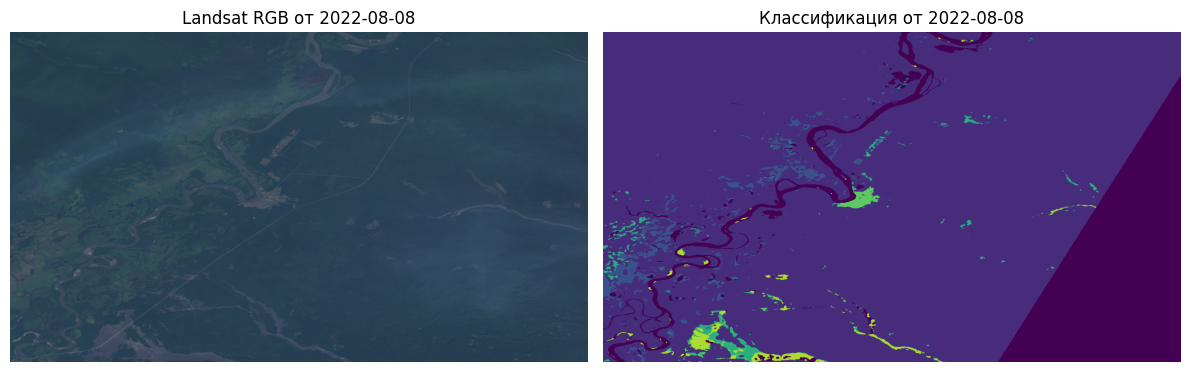

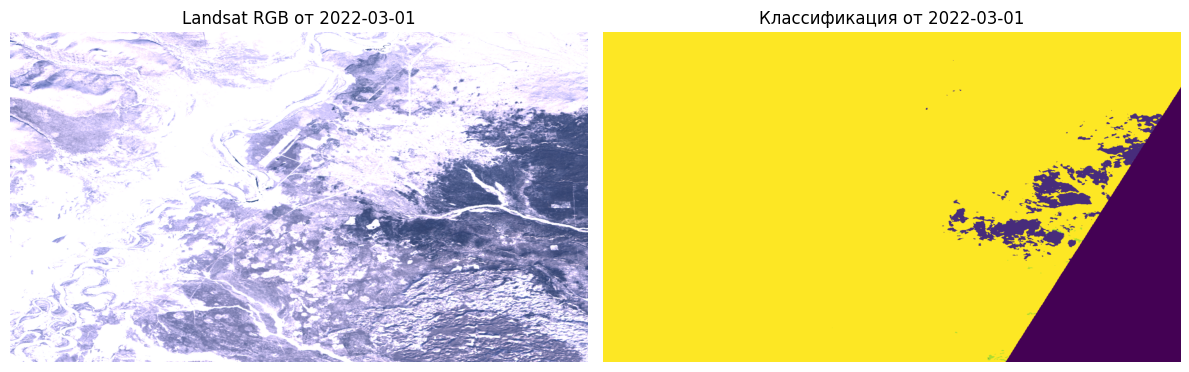

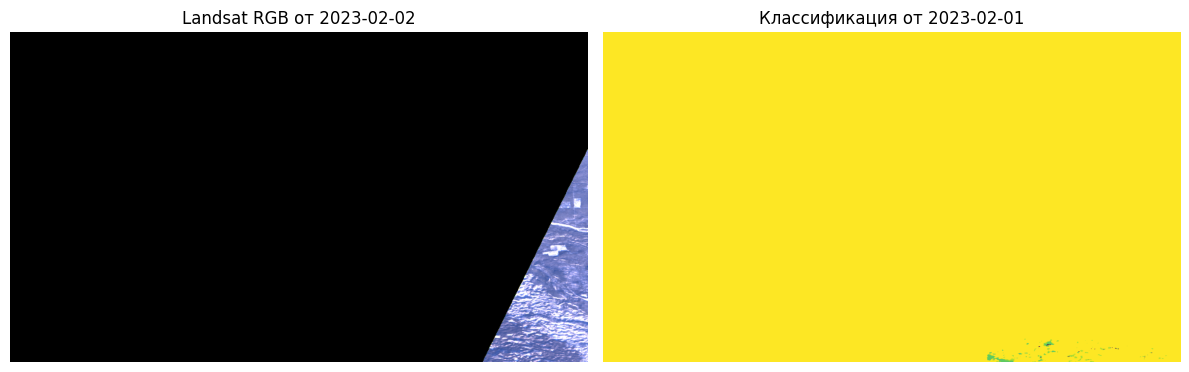

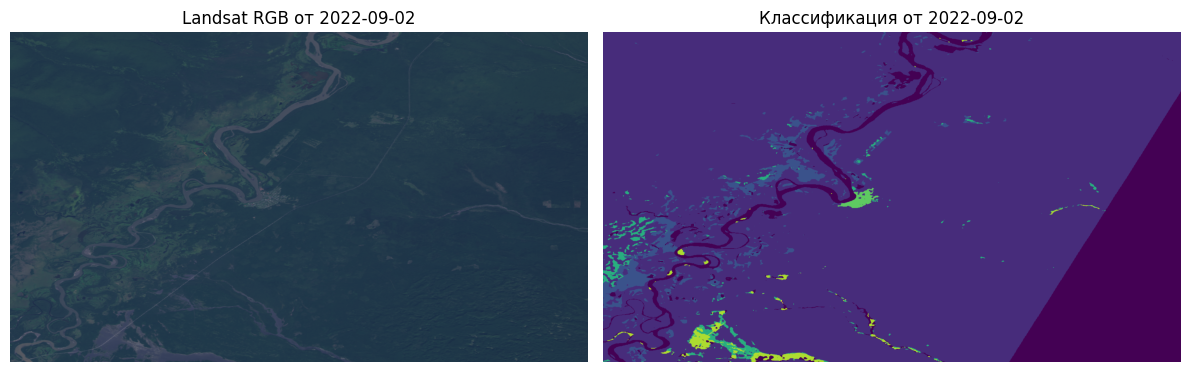

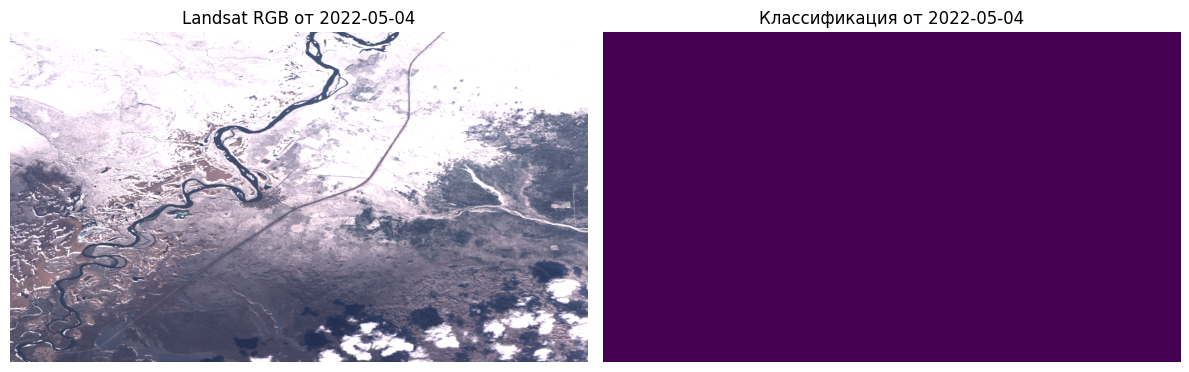

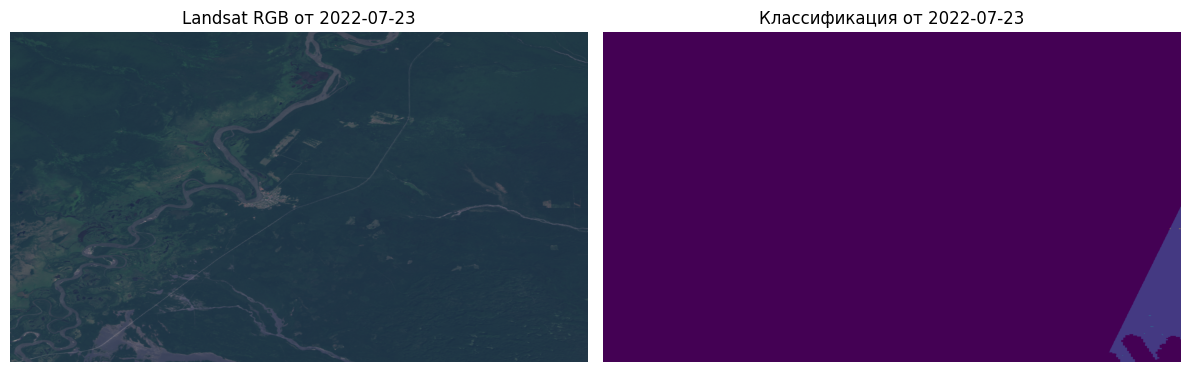

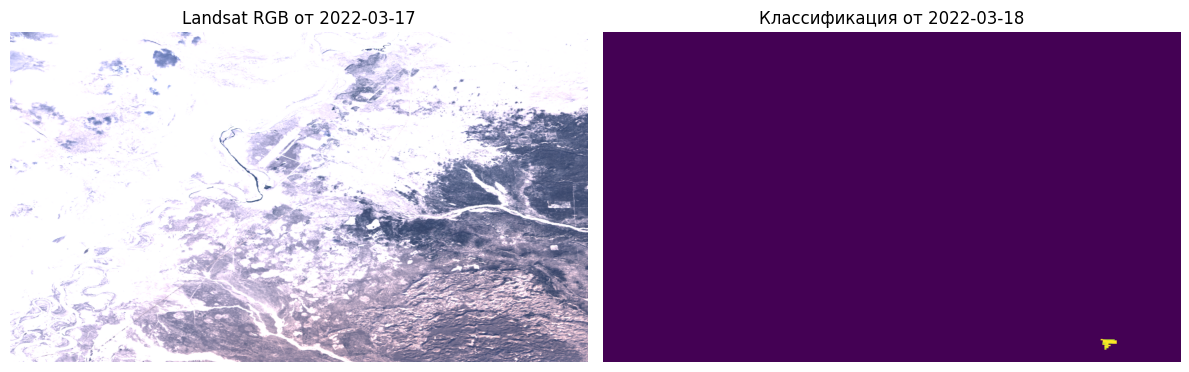

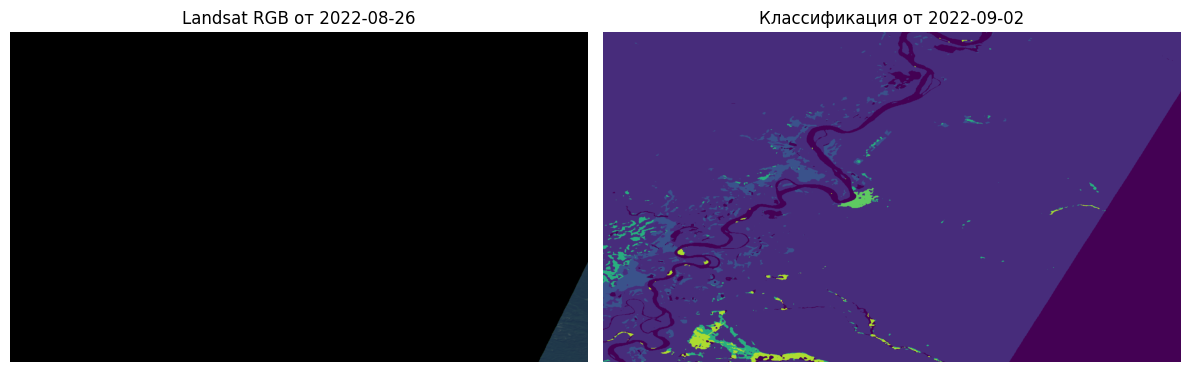

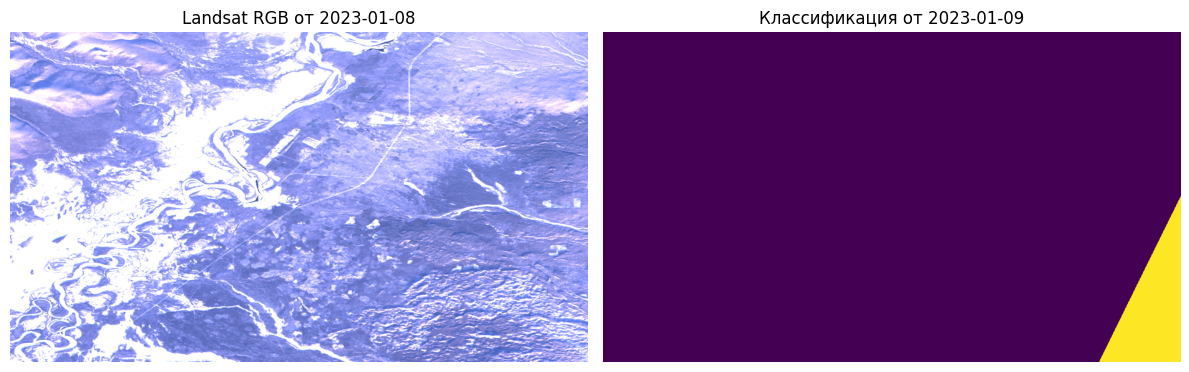

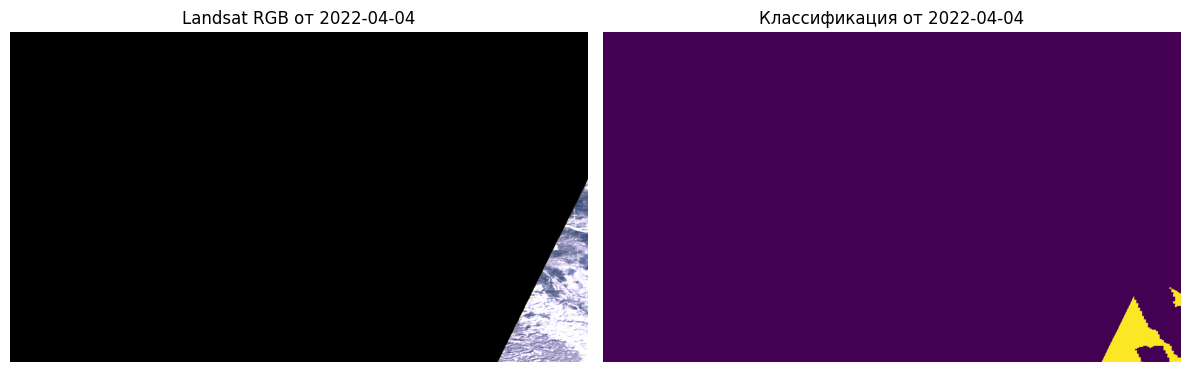

In [ ]:
# Визуализация первых трех загруженных пар для предпросмотра
for i, file_pair in enumerate(downloaded_files[:10]):
    try:
        # Чтение данных Landsat (RGB) с помощью библиотеки rasterio
        with rasterio.open(file_pair['landsat']) as src:
            rgb = src.read([1, 2, 3])           # Чтение каналов
            rgb = np.transpose(rgb, (1, 2, 0))  # Изменение порядка осей
            rgb = np.clip(rgb * 3.5, 0, 1)      # Улучшение контрастности

        # Чтение карты классификации
        with rasterio.open(file_pair['classification']) as src:
            classification = src.read(1)

        # Создание двухпанельного графика для визуализации пары изображений
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Отображение Landsat
        ax1.imshow(rgb)
        ax1.set_title(f"Landsat RGB от {file_pair['landsat_date']}")
        ax1.axis('off')

        # Отображение классификации
        ax2.imshow(classification, cmap='viridis')
        ax2.set_title(f"Классификация от {file_pair['classification_date']}")
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Ошибка при отображении пары {i+1}: {e}")
        continue

In [ ]:
# Функция для анализа метаданных файлов GeoTIFF
def print_geotiff_metadata(file_path):
    """Выводит ключевые метаданные файла GeoTIFF."""
    try:
        with rasterio.open(file_path) as src:
            print(f"Файл: {os.path.basename(file_path)}")
            print(f"  Система координат: {src.crs}")           # Проекция
            print(f"  Трансформация: {src.transform}")         # Аффинная матрица
            print(f"  Ширина: {src.width}, Высота: {src.height}")  # Размеры
            print(f"  Границы: {src.bounds}")                  # Координаты углов
            print(f"  Количество каналов: {src.count}")        # Число каналов
            print(f"  Значение отсутствия данных: {src.nodata}")  # NoData
    except Exception as e:
        print(f"Ошибка при чтении метаданных {os.path.basename(file_path)}: {e}")

# Проверка метаданных первой загруженной пары
if downloaded_files:
    print("\nМетаданные загруженных файлов GeoTIFF:")
    print_geotiff_metadata(downloaded_files[0]['landsat'])
    print_geotiff_metadata(downloaded_files[0]['classification'])


Метаданные загруженных файлов GeoTIFF:
Файл: landsat_2022-08-08.tif
  Система координат: EPSG:4326
  Трансформация: | 0.00, 0.00, 159.67|
| 0.00,-0.00, 56.18|
| 0.00, 0.00, 1.00|
  Ширина: 1683, Высота: 963
  Границы: BoundingBox(left=159.66583994717647, bottom=55.9214739093664, right=160.11939933412842, top=56.180997194948525)
  Количество каналов: 3
  Значение отсутствия данных: -inf
Файл: classification_2022-08-08_for_2022-08-08.tif
  Система координат: EPSG:4326
  Трансформация: | 0.00, 0.00, 159.67|
| 0.00,-0.00, 56.18|
| 0.00, 0.00, 1.00|
  Ширина: 1683, Высота: 963
  Границы: BoundingBox(left=159.66583994717647, bottom=55.9214739093664, right=160.11939933412842, top=56.180997194948525)
  Количество каналов: 1
  Значение отсутствия данных: 0.0


In [ ]:
# Создание CSV-файла с информацией о соответствии снимков и карт классификации
if downloaded_files:
    import csv
    correspondence_file = os.path.join(output_folder, "image_pairs_correspondence.csv")

    with open(correspondence_file, 'w', newline='') as csvfile:
        # Определение структуры файла
        fieldnames = ['landsat_date', 'landsat_file', 'classification_date', 'classification_file']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Запись данных
        writer.writeheader()
        for pair in downloaded_files:
            writer.writerow({
                'landsat_date': pair['landsat_date'],
                'landsat_file': os.path.basename(pair['landsat']),
                'classification_date': pair['classification_date'],
                'classification_file': os.path.basename(pair['classification'])
            })

    print(f"\nТаблица соответствий сохранена в {correspondence_file}")


Таблица соответствий сохранена в gee_downloaded_data/image_pairs_correspondence.csv


In [ ]:
import pandas as pd

df = pd.read_csv('gee_downloaded_data/image_pairs_correspondence.csv')
df.head(15)

,landsat_date,landsat_file,classification_date,classification_file
0,2022-08-08,landsat_2022-08-08.tif,2022-08-08,classification_2022-08-08_for_2022-08-08.tif
1,2022-03-01,landsat_2022-03-01.tif,2022-03-01,classification_2022-03-01_for_2022-03-01.tif
2,2023-02-02,landsat_2023-02-02.tif,2023-02-01,classification_2023-02-01_for_2023-02-02.tif
3,2022-09-02,landsat_2022-09-02.tif,2022-09-02,classification_2022-09-02_for_2022-09-02.tif
4,2022-05-04,landsat_2022-05-04.tif,2022-05-04,classification_2022-05-04_for_2022-05-04.tif
5,2022-07-23,landsat_2022-07-23.tif,2022-07-23,classification_2022-07-23_for_2022-07-23.tif
6,2022-03-17,landsat_2022-03-17.tif,2022-03-18,classification_2022-03-18_for_2022-03-17.tif
7,2022-08-26,landsat_2022-08-26.tif,2022-09-02,classification_2022-09-02_for_2022-08-26.tif
8,2023-01-08,landsat_2023-01-08.tif,2023-01-09,classification_2023-01-09_for_2023-01-08.tif
9,2022-04-04,landsat_2022-04-04.tif,2022-04-04,classification_2022-04-04_for_2022-04-04.tif


## **2. Подготовка данных и обучение модели**

In [ ]:
!pip install elephas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled 

In [ ]:
!pip install tensorflow==2.12

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.1 MB/s eta 0:00:00
  

In [ ]:
!pip install findspark

In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import findspark

findspark.init()

In [ ]:
# conf = SparkConf().setMaster("local").setAppName("Data Analysis")
# sc = SparkContext(conf = conf)
# spark = SparkSession(sc)

spark = SparkSession.builder \
    .appName("LandSegmentation") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.3.0 which is incompatible.
elephas 6.2.1 requires numpy==1.23.5, but you have numpy 2.3.0 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.30 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 w

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.optimizers.legacy import Adam, SGD

from elephas.ml_model import ElephasEstimator
from elephas.ml.adapter import to_data_frame

from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, MinMaxScaler, VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StructType, StructField, ArrayType, IntegerType, FloatType
from pyspark.ml.linalg import Vectors, VectorUDT

import numpy as np
import rasterio
import os

In [ ]:
data_dir = "/content/gee_downloaded_data"
csv_path = "/content/gee_downloaded_data/image_pairs_correspondence.csv"

pairs_df = spark.read.csv(csv_path, header=True, inferSchema=True)
pairs_df.show(5)

# Функция для чтения GeoTIFF и нарезки на тайлы
def read_and_tile_geotiff(image_path, mask_path, tile_size=128):
    """
    Читает GeoTIFF файлы (снимок и маску), проверяет их размеры и нарезает на тайлы.
    Возвращает список кортежей (image_tile, mask_tile).
    """
    try:
        # Чтение изображения
        with rasterio.open(image_path) as img:
            image = img.read()  # Формат: (bands, height, width)
            image = np.transpose(image, (1, 2, 0))  # Перевод в (height, width, bands)

        # Чтение маски
        with rasterio.open(mask_path) as mask:
            mask_data = mask.read(1)  # Маска одноканальная

        # Проверка размеров
        if image.shape[0:2] != mask_data.shape:
            print(f"Размеры не совпадают: изображение {image.shape}, маска {mask_data.shape}")
            return []

        # Нарезка на тайлы
        height, width, _ = image.shape
        tiles = []
        for i in range(0, height, tile_size):
            for j in range(0, width, tile_size):
                tile_image = image[i:i+tile_size, j:j+tile_size, :]
                tile_mask = mask_data[i:i+tile_size, j:j+tile_size]
                # Пропускаем тайлы с некорректными размерами
                if tile_image.shape[0] == tile_size and tile_image.shape[1] == tile_size:
                    tiles.append((tile_image.flatten().astype(np.float32).tolist(),
                                tile_mask.flatten().astype(np.int32).tolist()))
        return tiles
    except Exception as e:
        print(f"Ошибка при обработке {image_path}: {e}")
        return []

# Функция для обработки пар снимков и масок
def process_pairs(row):
    """
    Обрабатывает строку из CSV, добавляя полный путь к файлам.
    """
    image_file = os.path.join(data_dir, row['landsat_file'])
    mask_file = os.path.join(data_dir, row['classification_file'])
    return read_and_tile_geotiff(image_file, mask_file)

# Применяем обработку к DataFrame
rdd = pairs_df.rdd.flatMap(process_pairs)

# Определяем схему для Spark DataFrame
schema = StructType([
    StructField("image_tile", ArrayType(FloatType()), False),
    StructField("mask_tile", ArrayType(IntegerType()), False)  # Изменено на IntegerType
])

# Создаем DataFrame из тайлов
tiles_df = spark.createDataFrame(rdd, schema)
tiles_df.printSchema()

# Преобразование array<float> в VectorUDT для image_tile
def to_vector(arr):
    """
    Преобразует список в VectorUDT.
    """
    return Vectors.dense(arr)

to_vector_udf = udf(to_vector, VectorUDT())
tiles_df = tiles_df.withColumn("features", to_vector_udf(tiles_df["image_tile"]))

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(tiles_df)
tiles_df = scaler_model.transform(tiles_df)

# Преобразование масок в one-hot encoding
def to_one_hot(mask, num_classes=3):
    """
    Преобразует маску в one-hot encoding.
    """
    mask = np.array(mask).reshape(128, 128)
    one_hot = np.zeros((128, 128, num_classes), dtype=np.float32)
    for c in range(num_classes):
        one_hot[:, :, c] = (mask == c).astype(np.float32)
    return one_hot.flatten().tolist()

to_one_hot_udf = udf(lambda x: to_one_hot(x, num_classes=3), ArrayType(FloatType()))

tiles_df = tiles_df.withColumn("label", to_one_hot_udf(tiles_df["mask_tile"]))

train_df, test_df = tiles_df.randomSplit([0.8, 0.2], seed=42)

train_df.select("scaled_features", "label").show(5, truncate=50)

+------------+--------------------+-------------------+--------------------+
|landsat_date|        landsat_file|classification_date| classification_file|
+------------+--------------------+-------------------+--------------------+
|  2022-08-08|landsat_2022-08-0...|         2022-08-08|classification_20...|
|  2022-03-01|landsat_2022-03-0...|         2022-03-01|classification_20...|
|  2023-02-02|landsat_2023-02-0...|         2023-02-01|classification_20...|
|  2022-09-02|landsat_2022-09-0...|         2022-09-02|classification_20...|
|  2022-05-04|landsat_2022-05-0...|         2022-05-04|classification_20...|
+------------+--------------------+-------------------+--------------------+
only showing top 5 rows

root
 |-- image_tile: array (nullable = false)
 |    |-- element: float (containsNull = true)
 |-- mask_tile: array (nullable = false)
 |    |-- element: integer (containsNull = true)

+--------------------------------------------------+---------------------------------------------

In [ ]:
tiles_df.select("image_tile").show(5, truncate=50)

+--------------------------------------------------+
|                                        image_tile|
+--------------------------------------------------+
|[0.04000681, 0.06665129, 0.086935304, 0.0400068...|
|[0.044336203, 0.074481614, 0.08928707, 0.045405...|
|[0.044817246, 0.075817846, 0.089500874, 0.04446...|
|[0.045164667, 0.06894961, 0.092788, 0.045164667...|
|[0.042037886, 0.06967118, 0.090837106, 0.042545...|
+--------------------------------------------------+
only showing top 5 rows



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from elephas.ml_model import ElephasEstimator
from elephas.utils.rdd_utils import to_simple_rdd
import tensorflow as tf

# print(f"Количество обучающих тайлов: {train_df.count()}")
# print(f"Количество тестовых тайлов: {test_df.count()}")

tiles_df = tiles_df.withColumn("scaled_features", col("image_tile"))
train_df, test_df = tiles_df.randomSplit([0.8, 0.2], seed=42)

# U-Net модель
def create_unet_model(input_shape=(128, 128, 4), num_classes=3):
    """
    Создает упрощенную U-Net модель для сегментации.
    """
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)

    # Decoder
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, 3, activation='relu', padding='same')(u4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, 3, activation='relu', padding='same')(u5)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

unet_model = create_unet_model()

# Преобразование DataFrame в RDD для Elephas
def to_vector(arr):
    return Vectors.dense(arr)

to_vector_udf = udf(to_vector, VectorUDT())
train_df = train_df.withColumn("features", to_vector_udf(train_df["scaled_features"]))
test_df = test_df.withColumn("features", to_vector_udf(test_df["scaled_features"]))

estimator = ElephasEstimator()
estimator.set_keras_model_config(unet_model.to_json())
estimator.set_optimizer_config("adam")
estimator.set_loss("categorical_crossentropy")
estimator.set_metrics(["accuracy"])
estimator.set_epochs(10)
estimator.set_batch_size(32)
estimator.setFeaturesCol("features")
estimator.setLabelCol("label")
estimator.set_validation_split(0.1)
estimator.set_num_workers(1)
estimator.set_mode("synchronous")

fitted_model = estimator.fit(train_df)

predictions = fitted_model.transform(test_df)
predictions.select("features", "label", "prediction").show(5, truncate=50)

>>> Fit model


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pyspark/serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/usr/local/lib/python3.11/dist-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
           ^^^^^^^^^^^^^^^^^^^^^^^
TypeError: cannot pickle 'weakref.ReferenceType' object


PicklingError: Could not serialize object: TypeError: cannot pickle 'weakref.ReferenceType' object